In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

import random

In [3]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/sepal-user/module-venv/gwl-modeling/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
explain_vars = [
    "doy",
    "LIA",
    "VH",
    "VV",
    "VVVH_ratio",
    "angle",
    "sm_1",
    "sm_3",
    "sm_7",
    "sm_30",
    "precipitation",
    "prec_3",
    "prec_7",
    "prec_30",
    "elevation",
    "aspect",
    "slope",
    "land_cov",
    "canopy_height",
    "gldas_mean",
    "gldas_stddev",
    "B3",
    "B4",
    "B5",
    "B7",
    "ndvi",
    "ndmi",
    "ndbri",
    "doy"
]
response_var = ["gwl_cm"]
len(explain_vars)

29

# 1. Read in the data

In [5]:
explanatory_file_path = "data/7_training_data/explanatory_with_response_var_and_source.csv"
df = pd.read_csv(explanatory_file_path)
print("lenght of df: ", len(df))
# Drop duplicates on id and date
df = df.drop_duplicates(subset=["id", "date"])
print("lenght of df after dropping duplicates: ", len(df))

# Find if there are any NaNs and remove them from the dataset 
# Some NAN values are still present in the dataset, probably due to the fact that some of the
# points fall outside bounds of GLDSA dataset
df = df[~df.isna().any(axis=1)]

print("lenght of df after droping any nan values: ", len(df))

lenght of df:  34230
lenght of df after dropping duplicates:  33366
lenght of df after droping any nan values:  32340


## 2. Add regions to the points

<center><img src="img/training_regions.png" alt="image" width="900"/></center>
<p>Below we will add the region attribute to each of the points, this will be useful if we want to train different models over different subsets.</p>

In [6]:
shp_path = Path("data/0_shp/")
region_path = "regions_to_request_explanatory_all.gpkg"
gdf_regions = gpd.GeoDataFrame.from_file(shp_path/region_path)

unique_coords = df[["id", 'lon', 'lat']].drop_duplicates()
len(df), len(unique_coords)

# Create geodataframe from x y coordinates
station_with_region_df = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.lon, unique_coords.lat), crs="EPSG:4326")

# # Add the region id to each point
station_with_region_df = gpd.sjoin(station_with_region_df, gdf_regions[["region_id", "geometry"]], how="left", predicate="within")

# Merge the region id to the main dataframe
df = df.merge(station_with_region_df[["id", "region_id"]], on="id", how="left")
df

,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,...,gldas_stddev,B3,B4,B5,B7,ndvi,ndmi,ndbri,doy,region_id
0,wal,02_AHL_SBG-B076,2021-06-01,-41.000,3.937760,117.007750,32.785855,-11.481278,-5.556430,0.207099,...,1.817817,21,97,61,25,0.644068,0.227848,0.590164,152,10
1,wal,02_AHL_SBG-B076,2021-08-24,-38.000,3.937760,117.007750,32.785295,-12.812067,-5.960235,0.201164,...,1.817817,21,97,61,25,0.644068,0.227848,0.590164,236,10
2,wal,02_AHL_SBG-B076,2022-04-09,-22.000,3.937760,117.007750,32.795191,-18.437775,-10.636812,0.072032,...,1.817817,33,70,96,52,0.359223,-0.156627,0.147541,99,10
3,wal,02_AHL_SBG-B076,2023-02-15,-31.000,3.937760,117.007750,32.793740,-13.051827,-9.007584,0.076149,...,1.817817,33,70,96,52,0.359223,-0.156627,0.147541,46,10
4,wal,02_AHL_SBG-B101,2021-06-01,-66.000,3.931860,117.010120,39.267563,-9.778736,-6.648683,0.111111,...,1.811218,21,75,57,25,0.562500,0.136364,0.500000,152,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32335,old_brg,kalteng1,2020-03-31,-0.271,-2.319728,114.058131,32.480674,-13.179518,-7.523130,0.128794,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,91,8
32336,old_brg,kalteng1,2020-04-12,-0.114,-2.319728,114.058131,32.474638,-12.679995,-7.348031,0.130210,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,103,8
32337,old_brg,kecil1,2019-03-01,-2.954,-2.856089,113.805611,35.143679,-10.922965,-7.574065,0.093967,...,3.362376,24,76,69,32,0.520000,0.048276,0.407407,60,8
32338,old_brg,kecil1,2019-06-29,-2.922,-2.856089,113.805611,35.139013,-11.637249,-7.424729,0.112345,...,3.362376,24,76,69,32,0.520000,0.048276,0.407407,180,8


In [7]:
# count the number of points per region
df.groupby("region_id").count()["id"]

region_id
1       248
2      3769
3        77
4      7595
5     14076
6       397
7      2961
8      2548
9       242
10      427
Name: id, dtype: int64

## Exploratory: Get the count of the number of dates for each point

In [9]:
# group by id and get the number of dates for each id
df_grouped = df.groupby("id").count().reset_index()
df_grouped = df_grouped[["id", "date"]]
df_grouped.columns = ["id", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

,id,date_count
1968,BRG_150710_03,261
1967,BRG_150710_02,229
1957,BRG_140806_01,228
745,15_RAPP_PPDV-05a,212
779,15_RAPP_PPDVIII-23,206
...,...,...
1269,199_GAL_B36,1
262,10_MTI_MTI_H175_P3,1
272,10_MTI_MTI_H181_P3,1
280,10_MTI_MTI_H193_P3,1


In [8]:
df_grouped = df[df.region_id==5].groupby("id").count().reset_index()
df_grouped = df_grouped[["id", "date"]]
df_grouped.columns = ["id", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

,id,date_count
704,BRG_140806_01,228
87,15_RAPP_PPDV-05a,212
121,15_RAPP_PPDVIII-23,206
324,15_RAPP_TP-IV-23,203
72,15_RAPP_PPDIV-17,198
...,...,...
234,15_RAPP_SKM/XII-10,1
193,15_RAPP_SKM/IX-17a,1
233,15_RAPP_SKM/XII-06a,1
195,15_RAPP_SKM/IX-21,1


## Create a boxplot showing the number of dates per each point

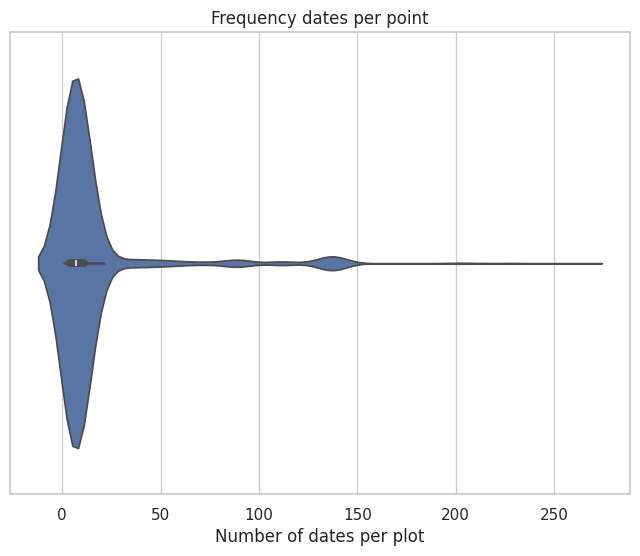

In [10]:
# Define the dimensions of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a violin plot for the variable
sns.violinplot(x=df_grouped["date_count"])

# Set the title and x-axis label
plt.title(f"Frequency dates per point")
plt.xlabel("Number of dates per plot")

plt.show()

## Question: 

## Get the percentiles of number of dates per plot distribution

In [11]:
# Define the percentiles you want to calculate as a list
percentiles = [0,5,10,25,50,75,90,100]  # You can adjust this list as needed

# Calculate the percentiles using numpy.percentile
percentile_values = np.percentile(df_grouped["date_count"], percentiles)

# Display the percentiles as a list
percentile_list = list(zip(percentiles, percentile_values))
print("Percentiles:")
for p, value in percentile_list:
    print(f"{p}th percentile: {value}")
    
percentile_list

Percentiles:
0th percentile: 1.0
5th percentile: 2.0
10th percentile: 3.0
25th percentile: 4.0
50th percentile: 7.0
75th percentile: 11.0
90th percentile: 21.600000000000136
100th percentile: 261.0


[(0, 1.0),
 (5, 2.0),
 (10, 3.0),
 (25, 4.0),
 (50, 7.0),
 (75, 11.0),
 (90, 21.600000000000136),
 (100, 261.0)]

In [27]:
perc_50_ids = df_grouped[df_grouped.date_count > percentile_list[4][0]].id.unique()

perc_df = df[df.id.isin(perc_50_ids)]
print("Before filteringout:", len(df))
print("After filtering", len(perc_df))

Before filteringout: 32340
After filtering 8463


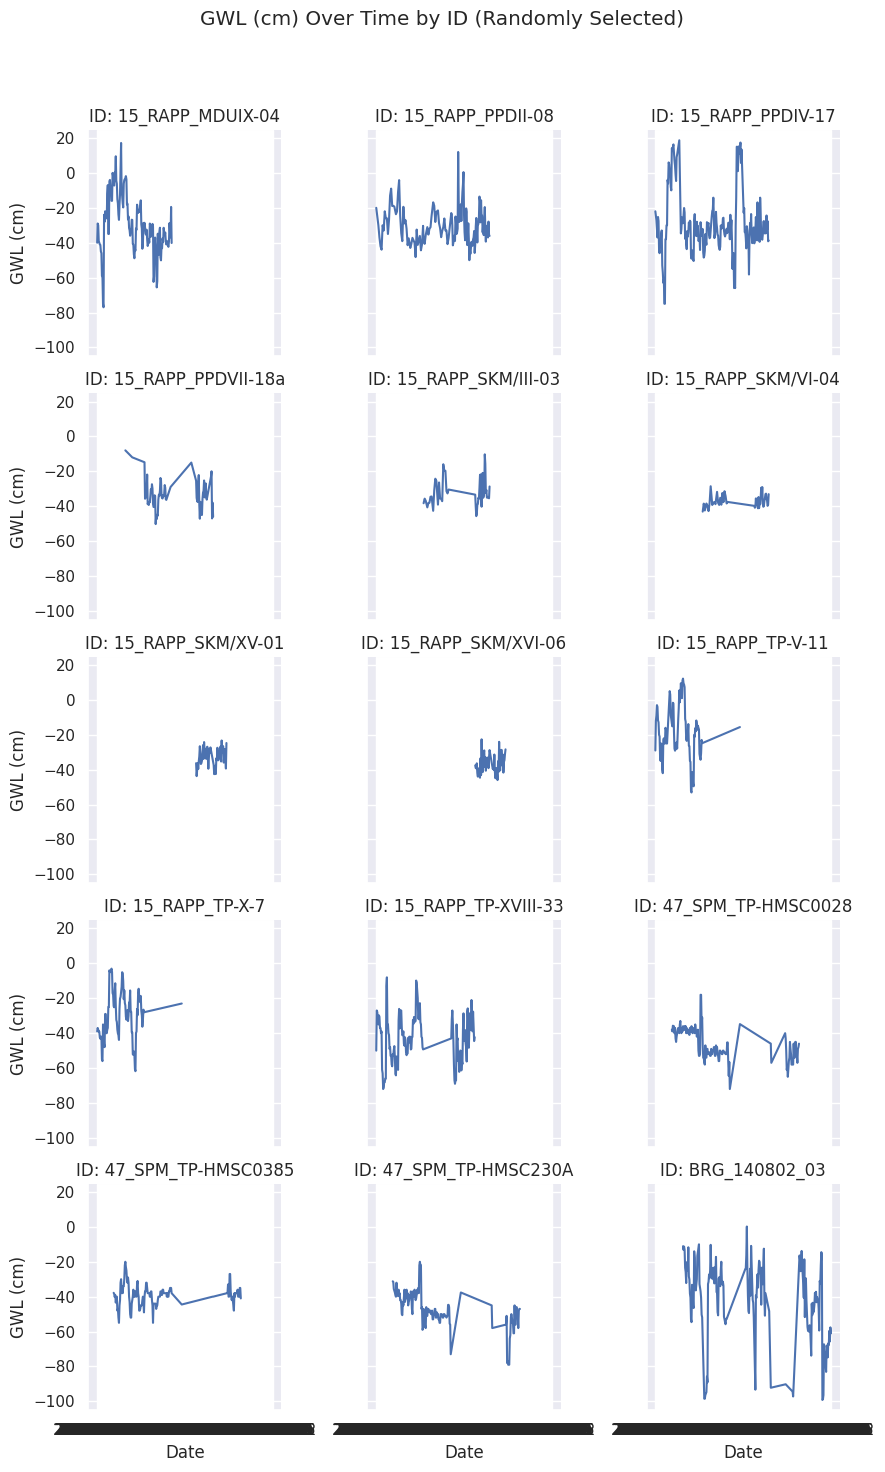

In [32]:
# Assuming you have a DataFrame named "df" with columns "date," "gwl_cm," and "id" (which is a string variable)

# Get the unique "id" values
unique_ids = perc_df["id"].unique()

# Select 15 random "id" values from the unique "id" list
random_ids = pd.DataFrame(perc_df.id.unique()).sample(15).iloc[:,0].tolist()

# Filter the DataFrame to include only the selected random "id" values
filtered_df = perc_df[perc_df["id"].isin(random_ids)]

sns.set(style="darkgrid")
g = sns.FacetGrid(filtered_df, col="id", col_wrap=3)
g.map(sns.lineplot, "date", "gwl_cm")
g.set_axis_labels("Date", "GWL (cm)")
g.set_titles("ID: {col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("GWL (cm) Over Time by ID (Randomly Selected)")
plt.show()

In [ ]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

In [ ]:
# Filter the DataFrame for the specific point '15_RAPP_PPDV-05a'
point_df = df[df.id == '15_RAPP_PPDV-05a']

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=point_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="precipitation", data=point_df, color='red', label="Precipitation (mm)")

# Set the second y-axis label
ax2.set_ylabel("Precipitation (mm)", color='tab:red')

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Set the title and x-axis label
plt.title(f"Point 15_RAPP_PPDV-05a - GWL and Precipitation Over Time")
plt.xlabel("Date")

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()

In [ ]:
# Filter the DataFrame for the specific region
region_df = df[df.region_id == 8]

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=region_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="precipitation", data=region_df, color='red', label="Precipitation (mm)")

# Set the second y-axis label
ax2.set_ylabel("Precipitation (mm)", color='tab:red')

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Set the title and x-axis label
plt.title(f"Region {8} - GWL and Precipitation Over Time")
plt.xlabel("Date")

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

## Compare GWL and simulated Soil Moisture

In [ ]:
# Filter the DataFrame for the specific region
region_df = df[df.region_id == 8]

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=region_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="sm_1", data=region_df, color='red', label="Soil moisture daily")

# Set the second y-axis label
ax2.set_ylabel("Soil moisture daily", color='tab:red')

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Set the title and x-axis label
plt.title(f"Region {8} - GWL and Soil moisture daily Over Time")
plt.xlabel("Date")

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

In [ ]:
# Filter the DataFrame for the specific region
region_df = df[df.region_id == 4]

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

# Create the first y-axis for "gwl" data
ax1 = sns.lineplot(x="date", y="gwl_cm", data=region_df, label="GWL (cm)")

# Set the first y-axis label
ax1.set_ylabel("GWL (cm)", color='tab:blue')

# Create the second y-axis for "precipitation" data
ax2 = ax1.twinx()
sns.lineplot(x="date", y="precipitation", data=region_df, color='red', label="Precipitation (mm)")

# Set the second y-axis label
ax2.set_ylabel("Precipitation (mm)", color='tab:red')

# Set the title and x-axis label
plt.title(f"Region {4} - GWL and Precipitation Over Time")
plt.xlabel("Date")

# Use MonthLocator for sparse labeling
ax1.xaxis.set_major_locator(MonthLocator())

# Add legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()

# 3. Identify outliers


When dealing with outliers in data, it's essential to adopt a systematic approach, and there are various statistical methods to identify and handle them. Here are some commonly used techniques to detect and remove outliers:

### Z-Score:

The Z-score represents the number of standard deviations a data point is from the mean.
Typically, if the Z-score is greater than 3 or less than -3, the data point can be classified as an outlier.


### Interquartile Range (IQR):

The IQR is the range between the first quartile (25th percentile) and the third quartile (75th percentile) of the data.
Data points that lie 1.5 times the IQR below the first quartile or above the third quartile can be classified as outliers.

### Visual Methods:

Box plots (as you've shown) can visually represent outliers.
Scatter plots can also help visualize outliers in multi-dimensional data.


### Domain Knowledge:

Sometimes, domain expertise can provide thresholds beyond which values are implausible.


In [29]:
print("-----------------------------------------------------------------number of data with outliers")
len(df)

-----------------------------------------------------------------number of data with outliers


32340

### Calculate z-scores

In [30]:
from scipy import stats

# Calculate z-scores for the data
z_scores = stats.zscore(df['gwl_cm'])

# Define a threshold for considering values as outliers (e.g., z-score greater than 3)
threshold = 3

# Remove rows with values that have z-scores greater than the threshold
data_no_outliers = df[(z_scores < threshold) & (z_scores > -threshold)]

In [31]:
print("-----------------------------------------------------------------number of data with no outliers applying z-scores")
len(data_no_outliers)

-----------------------------------------------------------------number of data with no outliers applying z-scores


32258

### Check regions 3 and 9

In [ ]:
# Create descriptive statistics
df_region_3 = df[df.region_id == 3]
df_region_9 = df[df.region_id == 9]

problematic_regions = [3, 9]

In [ ]:
from matplotlib.dates import MonthLocator


# Set the figure size
fig, axs = plt.subplots(len(problematic_regions), 1, figsize=(6, 3*len(problematic_regions)))

# Iterate over the region IDs and create a separate plot for each region
for i, region_id in enumerate(problematic_regions):
    ax = axs[i]
    sns.lineplot(x="date", y="gwl_cm", data=df[df.region_id==region_id], ax=ax)
    ax.set_title(f"Region {region_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("GWL (cm)")

    # Use MonthLocator for sparse labeling
    ax.xaxis.set_major_locator(MonthLocator())


# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

## Discuss: Does the displayed values for this point make sense?

- Consider to remove problematic regions.

In [ ]:
df = df[~df.region_id.isin(problematic_regions)]

In [ ]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

In [ ]:
# Calculate Q1 and Q3 for each region
Q1 = df.groupby('region_id')['gwl_cm'].quantile(0.25)
Q3 = df.groupby('region_id')['gwl_cm'].quantile(0.75)

# Calculate IQR for each region
IQR = Q3 - Q1

# Define bounds for outliers for each region
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Map the lower and upper bounds for each region_id in df
df_lower_bound = df['region_id'].map(lower_bound)
df_upper_bound = df['region_id'].map(upper_bound)

# Filter out outliers
filtered_df = df[~((df['gwl_cm'] < df_lower_bound) | (df['gwl_cm'] > df_upper_bound))]
filtered_df

In [ ]:
# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=filtered_df, width=0.5)

## Question: What to do with values above 0?

In [ ]:
import matplotlib.pyplot as plt

# Get the unique region IDs
region_ids = sorted(filtered_df.region_id.unique())

# Set the figure size
fig, axs = plt.subplots(len(region_ids), 1, figsize=(9, 4*len(region_ids)))

# Iterate over the region IDs and create a separate plot for each region
for i, region_id in enumerate(region_ids):
    ax = axs[i]
    sns.lineplot(x="date", y="sm_1", data=filtered_df[filtered_df.region_id==region_id], ax=ax)
    ax.set_title(f"Region {region_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("GWL (cm)")

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Use MonthLocator for sparse labeling
    ax.xaxis.set_major_locator(MonthLocator())

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

# 3.1 Use the Domain Knowledge to further filter the data (if required)

Visually, does this data make sense?

# 4. Export the cleaned dataset to a CSV file

In [ ]:
filtered_df.to_csv("data/9_clean_training_data/clean_training_data.csv", index=False)